In [24]:
import pandas as pd
import numpy as np

import contractions
import string
from unidecode import unidecode
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, BisectingKMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import matplotlib.pyplot as plt

from time import process_time

In [26]:
def elapse_time():
    end = process_time()
    elapse_sec = end - start

    if elapse_sec >= 60:
        elapse_min = round(elapse_sec // 60)
        elapse_sec = round(elapse_sec - elapse_min * 60, 1)
        print(f"Time: {elapse_min}m {elapse_sec}s")
    else:
        print(f"Time: {round(elapse_sec, 1)}s")

start = process_time()

In [27]:
##### Data Retrieval #####

# Load the data
data = pd.read_csv(r'dataset/movies_metadata.csv')

# Explore the data
print("Number of columns:", len(data.columns))
print("Columns:", data.columns)
print("Number of rows:", len(data))

Number of columns: 24
Columns: Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')
Number of rows: 45466


C:\Users\b1ank\AppData\Local\Temp\ipykernel_6876\1231448154.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r'dataset/movies_metadata.csv')


In [28]:
##### Data Preprocessing #####

# Drop row if the overview has a NaN value
data = data.dropna(subset=['overview'])

# Drop row if the overview has the value of " "
data = data[data['overview'] != " "]

# Drop row if the overview has the value of "..."
data = data[data['overview'] != "..."]

# Drop row if the overview has some value of "No overview"
data = data[~data['overview'].str.contains('No overview', case=False)]

# Drop row if the overview is "Released"
data = data[data['overview'] != 'Released']

# Drop duplicates of overview but keep the first occurrence
data = data.drop_duplicates(subset=['overview'])

# Drop row if the imdb_id has a NaN value
data = data.dropna(subset=['imdb_id'])

# Drop duplicates of imdb_id but keep the first occurrence
data = data.drop_duplicates(subset=['imdb_id'])

print("Number of rows after preprocessing:", len(data)) # 44282 Rows


Number of rows after preprocessing: 44282


In [29]:
# Only use the 'imdb_id' and 'overview' to simulate a movie recommendation system
data = data[['imdb_id', 'overview']]

In [30]:
# Describe the data
data.describe()

,imdb_id,overview
count,44282,44282
unique,44282,44282
top,tt6980792,50 years after decriminalisation of homosexual...
freq,1,1


In [31]:
##### Natural Language Processing #####

def english_detect(text):
    try:
        text.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    

# def english_detect(text):
#     try:
#         return detect(text) == 'en'
#     except LangDetectException:
#         return False

In [32]:
def preprocess_text(text, word_length=30):

    # Remove extra spaces
    text = " ".join(text.split())

    # Special characters - Convert accented and special characters (é --> e)
    text = unidecode(text)

    # Lowercase letters (Then --> then)
    text = text.lower()

    # Expand contractions (Don't --> Do not)
    text = contractions.fix(text)

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Remove numbers
    text = ''.join([char for char in text if not char.isdigit()])

    # Tokenization (split text into words)
    tokens = word_tokenize(text)[:word_length]

    # Remove Stopwords - Words with little significance (a, an, the)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming - Remove suffixes of words to get base form of word ({watches, watching, watched} --> watch)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Remove words with 3 or more repeated characters in a row
    tokens = [word for word in tokens if not re.search(r"(.)\1\1", word)]

    result = ' '.join(tokens)

    # If the string is null, remove the row from the processed dataset
    if result == '':
        return False

    return result


In [33]:
# Drop rows that do not have English text for 'overview'
data = data[data['overview'].apply(english_detect)]
#data = data[data['overview'].apply(english_detect)] # 1m 44.2s


In [34]:
# Apply text preprocessing to all overviews
data['overview preprocessed'] = pd.DataFrame(data['overview'].apply(preprocess_text)) # 33.5s

In [35]:
print("Number of rows after preprocessing:", len(data)) # 44095 Rows # 39308 Rows

Number of rows after preprocessing: 39308


In [36]:
# Sampling without replacement
# data = resample(data, n_samples=20000, replace=False, random_state=42)

In [37]:
### Vectorization - Map Words/Phrases to Vectors

def vectorization(input, method):
    vectorizer = method
    vectors = vectorizer.fit_transform(input).toarray()
    
    # Extract feature names
    # Returns words in your corpus, sorted by position in the sparse matrix
    feature_names = vectorizer.get_feature_names_out()
    print("Amount of Features:", len(feature_names))
    print(feature_names)

    # Get the indices of each feature name
    print(vectorizer.vocabulary_)

    return vectors

### Supported Vectorization Methods:

## Bag of Words (Term Frequency) (Count Vectorizer)
# Captures raw word frequencies

## (TF-IDF) Term Frequency-Inverse Document Frequency 
# Uncommon words have higher weights


In [38]:
# min_df=8 to avoid MemoryError
# MemoryError: Unable to allocate 20.3 GiB for an array with shape (44095, 61862) and data type float64

method = TfidfVectorizer(min_df=5) # Amount of Features: 10100
vectors = vectorization(data['overview preprocessed'], method)

Amount of Features: 10100
['aaron' 'abandon' 'abba' ... 'zone' 'zoo' 'zulu']
{'led': 5069, 'woodi': 9963, 'andi': 309, 'toy': 9183, 'live': 5197, 'happili': 3944, 'room': 7642, 'birthday': 888, 'bring': 1091, 'buzz': 1208, 'onto': 6339, 'scene': 7835, 'afraid': 119, 'lose': 5256, 'place': 6766, 'heart': 4025, 'plot': 6798, 'sibl': 8146, 'judi': 4778, 'peter': 6676, 'discov': 2434, 'enchant': 2848, 'board': 945, 'game': 3551, 'open': 6341, 'door': 2542, 'magic': 5377, 'world': 9975, 'unwittingli': 9512, 'invit': 4575, 'alan': 171, 'adult': 91, 'trap': 9224, 'insid': 4495, 'cheat': 1462, 'mistreat': 5808, 'step': 8558, 'women': 9956, 'hold': 4176, 'breath': 1063, 'wait': 9752, 'elus': 2805, 'good': 3716, 'man': 5421, 'break': 1055, 'string': 8638, 'lover': 5278, 'friend': 3488, 'confid': 1799, 'berni': 829, 'georg': 3609, 'bank': 655, 'recov': 7306, 'daughter': 2149, 'wed': 9830, 'receiv': 7280, 'news': 6115, 'pregnant': 6928, 'wife': 9899, 'nina': 6156, 'expect': 3065, 'plan': 6770, 'ob

In [39]:
# Shape of vectors
print(vectors.shape)

(39308, 10100)


In [40]:
# Dimension Reduction
pca = PCA(n_components=2, random_state=42)
X = pca.fit_transform(vectors)

In [41]:
# Shape of vectors after preprocessing
print(X.shape)

(39308, 2)


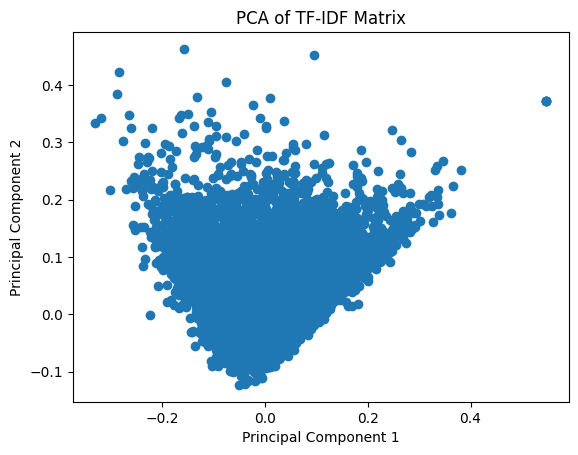

In [42]:
# Visualizing the data
plt.scatter(X[:, 0], X[:, 1], marker='o')
plt.title('PCA of TF-IDF Matrix')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [43]:
def calculate_sse(input, labels):
    sse = 0
    for cluster in np.unique(labels):
        cluster_points = input[labels == cluster]
        cluster_center = cluster_points.mean(axis=0)
        sse += np.sum((cluster_points - cluster_center) ** 2)
    return sse

In [44]:
# K-Means Clustering
def k_means(input, n_clusters):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    return model.fit(input)

def bisect_k_means(input, n_clusters):
    model = BisectingKMeans(n_clusters=n_clusters, random_state=42)
    return model.fit(input)

In [45]:
# K-Means Clustering - Optimize k Value
def elbow_kmean(input, kmax):
    sse_values = []

    # Iterate over different k values and calculate SSE
    for k in range(1, kmax+1):
        clustering = KMeans(n_clusters=k, random_state=42).fit(input)
        labels = clustering.labels_

        sse = calculate_sse(X, labels)
        sse_values.append(sse)

    # Plot the elbow method graph
    plt.plot(range(1, kmax+1), sse_values, marker='o')
    plt.title("Elbow Method for K-Means Clustering")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Sum of Squared Errors (SSE)")
    plt.show()

In [46]:
# Bisecting K-Means Clustering - Optimize k Value
def elbow_bisecting_kmean(input, kmax):
    sse_values = []

    # Iterate over different k values and calculate SSE
    kmax_range = range(1, kmax+1)
    for k in kmax_range:
        clustering = BisectingKMeans(n_clusters=k, random_state=42).fit(input)
        labels = clustering.labels_

        sse = calculate_sse(X, labels)
        sse_values.append(sse)

    # Plot the elbow method graph
    plt.plot(kmax_range, sse_values, marker='o')
    plt.title("Elbow Method for Bisecting K-Means Clustering")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Sum of Squared Errors (SSE)")
    plt.show()

In [47]:
# Hierarchical Clustering (Agglomerative)
def hierarchical(input, method, p, show_dendrogram=True, t=None):
    clustering = linkage(input, method=method)

    # Plot the dendrogram
    dn = None
    if show_dendrogram==True:
        plt.figure(figsize=(15,5))
        plt.title(method.title() + ' Agglomerative Clustering Dendrogram (truncated)')
        plt.xlabel('Samples')
        plt.ylabel('Distance')
        dn = dendrogram(clustering, truncate_mode='lastp', p=p, no_labels=True)
        plt.show()

    # Form Flat Clusters
    labels = None
    
    if t != None:
        labels = fcluster(clustering, t, criterion='maxclust')

    return clustering, dn, labels

In [48]:
# Hierarchical Clustering - Optimize k Value
def elbow_hierarchical(clustering, kmax, model_title, kmin=1):
    sse_values = []

    # Iterate over different k values and calculate SSE
    kmax_range = range(1, kmax+1)
    for k in kmax_range:
        labels = fcluster(clustering, k, criterion='maxclust')
        sse = calculate_sse(X, labels)
        sse_values.append(sse)

    # Plot the elbow method graph
    plt.plot(kmax_range, sse_values, marker='o')
    plt.title("Elbow Method for " + model_title.title() + " Hierarchical Clustering")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Sum of Squared Errors (SSE)")
    plt.show()

In [49]:
# DBSCAN - Density-Based Clustering
def density(input, eps, min_samples):
    return DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(input)

In [50]:
# Density-Based Clustering - Optimize EPS
def elbow_density_eps(input, min_x=35000, max_y=0.02):
    # Initial MinPts (2 * number of dimensions)
    min_samples = 2 * input.shape[1]

    # By k=min_samples, determine close distance as point in cluster
    knn = NearestNeighbors(n_neighbors=min_samples+1).fit(input)
    distance, _ = knn.kneighbors(input)

    # Sort disatance by ascending order
    # Drop the first point which has a distance of 0
    distance = np.sort(distance[:, -1])

    # Plot the elbow method graph
    plt.plot(distance, marker='o')
    plt.title("Elbow Method for Density-Based Clustering (optimizing eps)")
    plt.xlabel(f'Points Sorted According to Distance of {min_samples}th Nearest Neighbors')
    plt.ylabel(f'{min_samples}th Nearest Neighbor Distance')
    plt.xlim([min_x, len(distance)])
    plt.ylim([0, max_y])
    plt.show()

In [51]:
# Density-Based Clustering - Optimize min_samples
def elbow_density_min_samples(input, max_min_samples, eps=0.005):
    sse_values = []

    # Iterate over different k values and calculate SSE
    min_samples_range = range(2, max_min_samples+1)
    for min_samples in min_samples_range:
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        clustering = model.fit(input)
        labels = clustering.labels_
        sse = calculate_sse(X, labels)
        sse_values.append(sse)

    # Plot the elbow method graph
    plt.plot(min_samples_range, sse_values, marker='o')
    plt.title("Elbow Method for Density-Based Clustering (min_samples)")
    plt.xlabel("min_samples")
    plt.ylabel("Sum of Squared Errors (SSE)")
    plt.show()

In [52]:
# Count number of noise points
def noise_count(method):
    noise_points = np.sum(data[method] == -1)
    print(f"Number of noise points: {noise_points}")

In [53]:
# Concatenate the dataframe with the array of cluster labels
def cluster_df(dataset, labels, column_name):
    dataset.loc[:,column_name] = labels

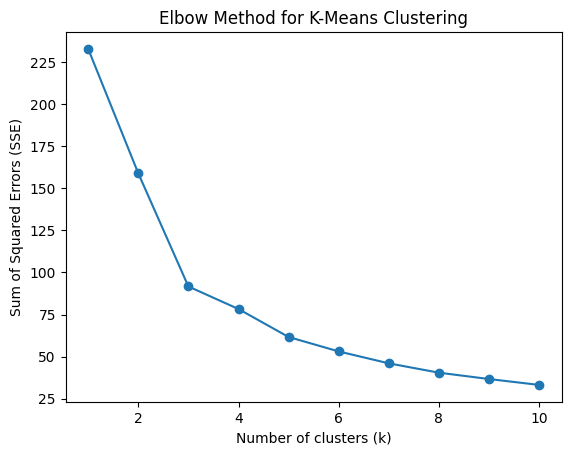

In [54]:
# Elbow Method - Optimize k value for k-means
elbow_kmean(X, kmax=10)
# optimal_k = 3

In [55]:
# Add cluster labels to dataframe
labels = k_means(X, n_clusters=3).labels_
cluster_df(data, labels, 'KMeans')

In [56]:
# Count number of noise points
# noise_count('KMeans')

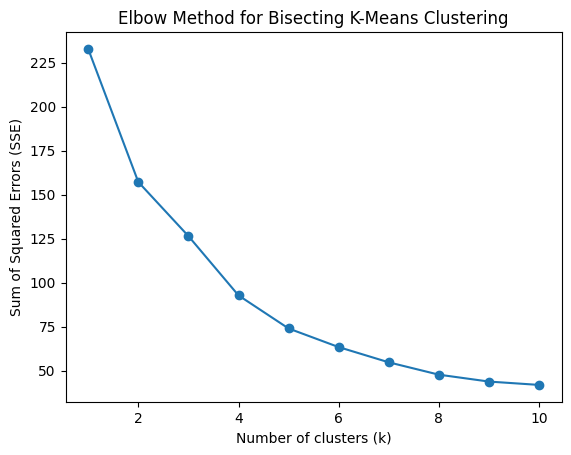

In [57]:
# Elbow Method - Optimize k value for bisecting k-means
elbow_bisecting_kmean(X, kmax=10)
# optimal_k = 3

In [58]:
# Add cluster labels to dataframe
labels = bisect_k_means(X, n_clusters=3).labels_
cluster_df(data, labels, 'Bisecting KMeans')

In [59]:
# Count number of noise points
# noise_count('Bisecting KMeans')

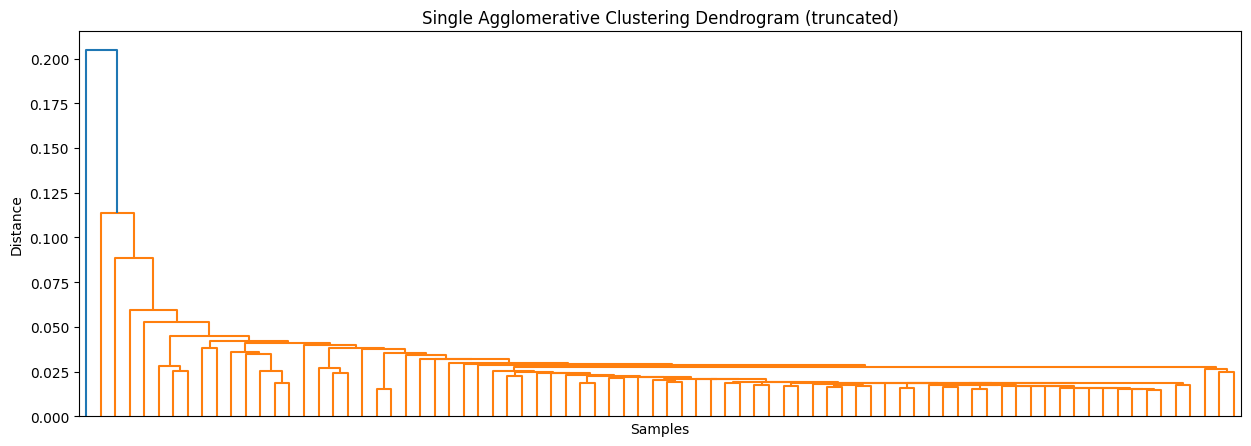

In [60]:
# 25.8s
single_clustering, single_dendrogram, labels = hierarchical(X, 'single', p=80, show_dendrogram=True, t=32)

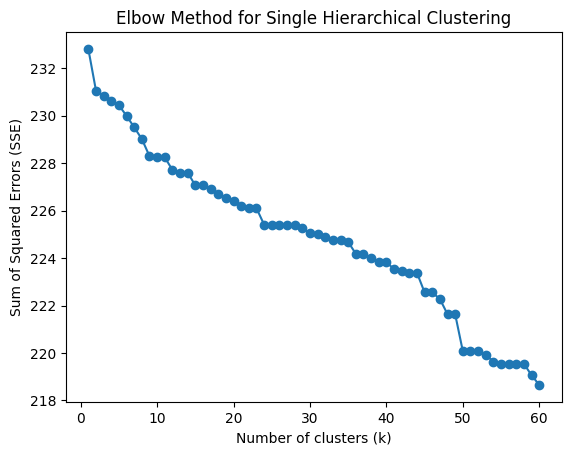

In [61]:
# Elbow Method - Optimize k value for single
elbow_hierarchical(single_clustering, kmax=60, model_title='single') #1m 49.9s
# optimal_k = 32

In [62]:
# Add cluster labels to dataframe
cluster_df(data, labels, 'Single Agglomerative')

In [63]:
# Count number of noise points
# noise_count('Single Agglomerative')

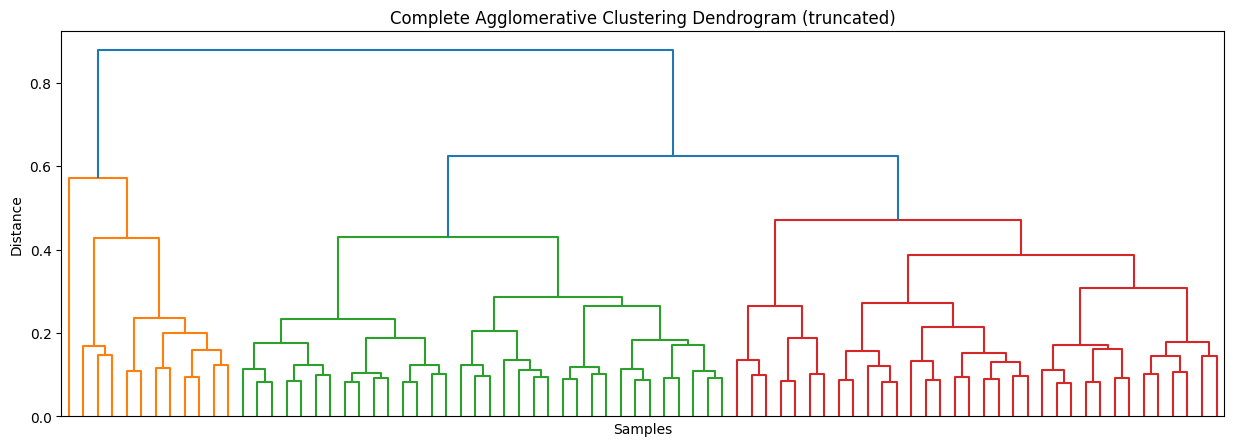

In [64]:
# 57.2s
complete_clustering, complete_dendrogram, labels = hierarchical(X, 'complete', p=80, show_dendrogram=True, t=21)

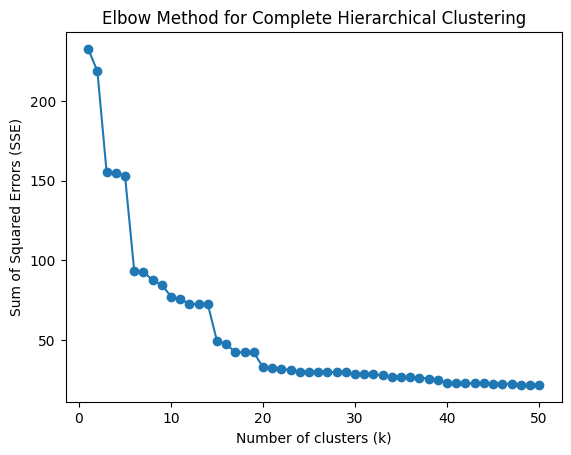

In [65]:
# Elbow Method - Optimize k value for complete
elbow_hierarchical(complete_clustering, kmax=50, model_title='complete') #2.6s
# optimal_k = 21

In [66]:
# Add cluster labels to dataframe
cluster_df(data, labels, 'Complete Agglomerative')

In [67]:
# Count number of noise points
# noise_count('Complete Agglomerative')

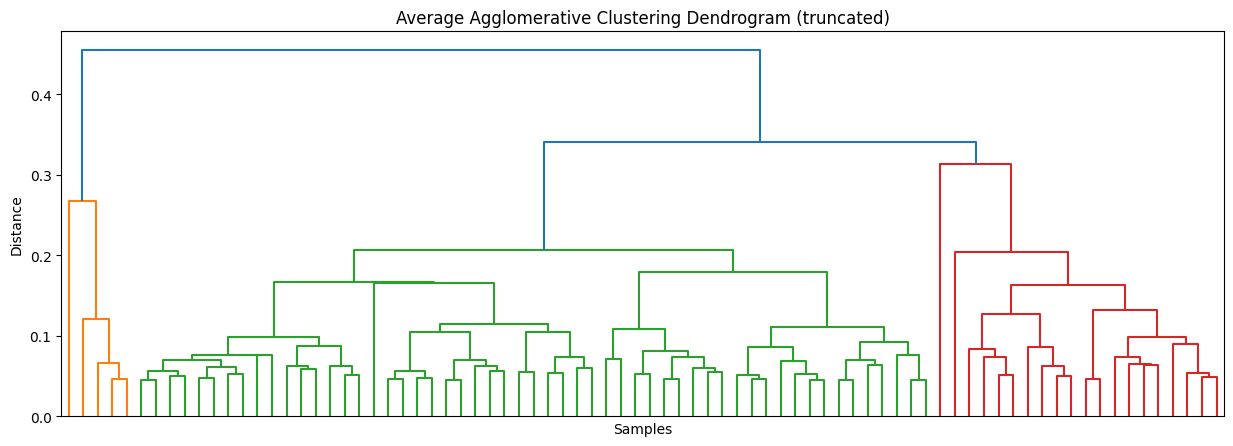

In [68]:
average_clustering, average_dendrogram, labels = hierarchical(X, 'average', p=80, show_dendrogram=True, t=15)

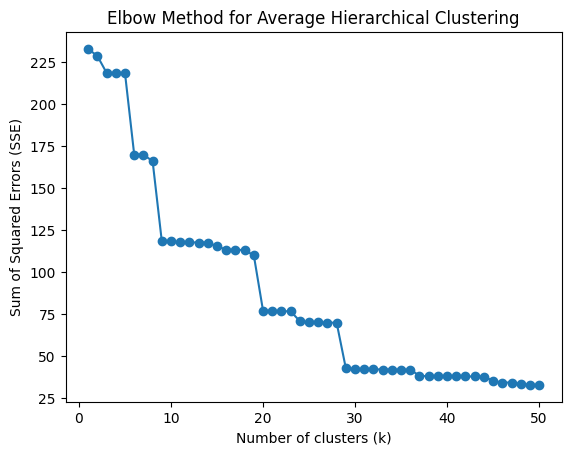

In [69]:
# Elbow Method - Optimize k value for average
elbow_hierarchical(average_clustering, kmax=50, model_title='average')
# optimal_k = 15

In [70]:
# Add cluster labels to dataframe
cluster_df(data, labels, 'Average Agglomerative')

In [71]:
# Count number of noise points
# noise_count('Average Agglomerative')

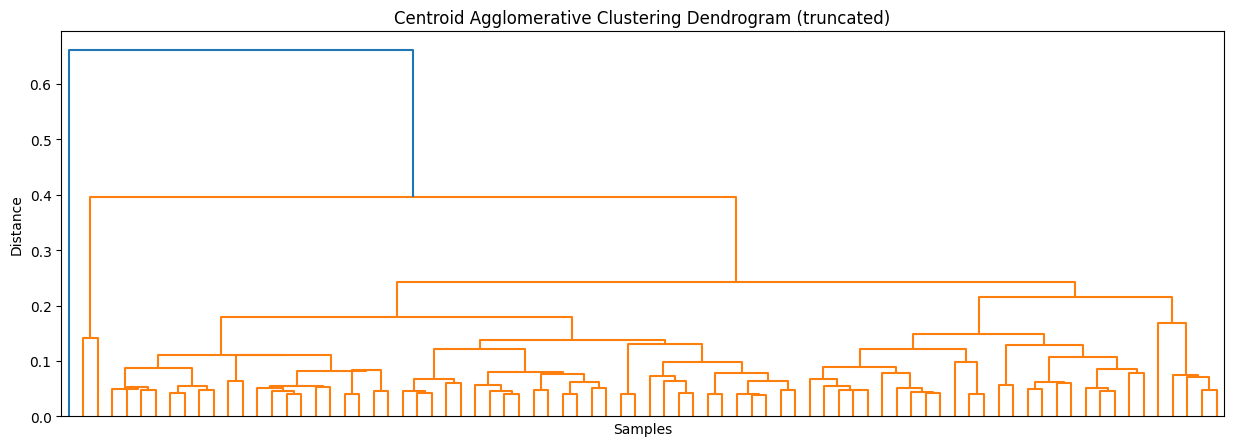

In [72]:
centroid_clustering, centroid_dendrogram, labels = hierarchical(X, 'centroid', p=80, show_dendrogram=True, t=21)

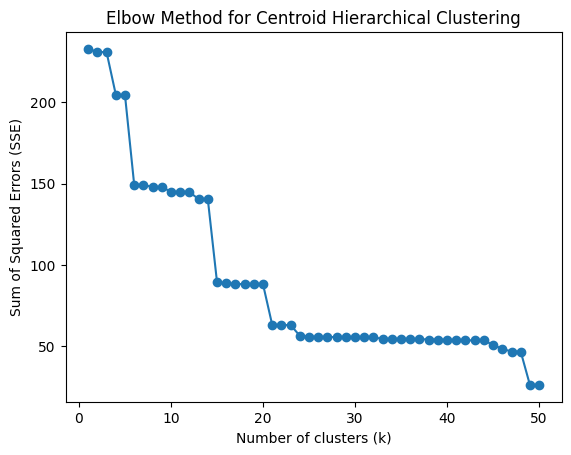

In [73]:
# Elbow Method - Optimize k value for centroid
elbow_hierarchical(centroid_clustering, kmax=50, model_title='centroid')
# optimal_k = 21

In [74]:
# Add cluster labels to dataframe
cluster_df(data, labels, 'Centroid Agglomerative')

In [75]:
# Count number of noise points
# noise_count('Centroid Agglomerative')

In [76]:
data.head()

,imdb_id,overview,overview preprocessed,KMeans,Bisecting KMeans,Single Agglomerative,Complete Agglomerative,Average Agglomerative,Centroid Agglomerative
0,tt0114709,"Led by Woody, Andy's toys live happily in his ...",led woodi andi toy live happili room andi birt...,0,1,16,7,4,4
1,tt0113497,When siblings Judy and Peter discover an encha...,sibl judi peter discov enchant board game open...,0,1,16,7,4,4
3,tt0114885,"Cheated on, mistreated and stepped on, the wom...",cheat mistreat step women hold breath wait elu...,0,2,16,6,4,4
4,tt0113041,Just when George Banks has recovered from his ...,georg bank recov daughter wed receiv news preg...,0,1,16,8,4,4
5,tt0113277,"Obsessive master thief, Neil McCauley leads a ...",obsess master thief neil mccauley lead topnotc...,0,0,16,7,4,4


In [77]:
# Get other similar results with same cluster index
cluster_result = lambda method, cluster_index : data.loc[data[method] == cluster_index]['imdb_id']

In [78]:
# Replace 'method' to change the clustering method
# Replace 'cluster_index' to search for entries that are related to the chosen cluster
print(cluster_result(method='Centroid Agglomerative', cluster_index=5))

25       tt0114057
27       tt0114117
34       tt0112637
46       tt0114369
83       tt0113612
           ...    
45430    tt0120200
45431    tt0072088
45432    tt0074124
45438    tt3814486
45460    tt0102797
Name: imdb_id, Length: 3673, dtype: object


In [79]:
# Elbow Method - Optimize eps value for DBSCAN
# elbow_density_eps(X) # eps = 0.005 # min_samples=4

In [80]:
# Elbow Method - Optimize min_samples value for DBSCAN
# elbow_density_min_samples(X, max_min_samples=20, eps=0.005)

In [81]:
# clustering = density(X, eps=1.0, min_samples=5) # 2m 52.0s

In [82]:
elapse_time() # 4m 46.5s

Time: 5m 3.6s
